In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# Caricamento del dataset CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

2025-05-05 18:15:01.117752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746468901.351258      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746468901.415878      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Train set: (50000, 32, 32, 3), (50000, 1)
Test set: (10000, 32, 32, 3), (10000, 1)


In [2]:
np.random.seed(42)

num_samples_to_keep_train = int(len(X_train) * 0.2)
num_samples_to_keep_test = int(len(X_test) * 0.2)

indices_to_keep_train = np.random.choice(len(X_train), num_samples_to_keep_train, replace=False)
indices_to_keep_test = np.random.choice(len(X_test), num_samples_to_keep_test, replace=False)

X_train_reduced = X_train[indices_to_keep_train]
y_train_reduced = y_train[indices_to_keep_train]
X_test_reduced = X_test[indices_to_keep_test]
y_test_reduced = y_test[indices_to_keep_test]

print(f"Reduced Train set: {X_train_reduced.shape}, {y_train_reduced.shape}")
print(f"Reduced Test set: {X_test_reduced.shape}, {y_test_reduced.shape}")

Reduced Train set: (10000, 32, 32, 3), (10000, 1)
Reduced Test set: (2000, 32, 32, 3), (2000, 1)


In [3]:
# Flatten delle immagini
X_train_flat = X_train_reduced.reshape(X_train_reduced.shape[0], -1)
X_test_flat = X_test_reduced.reshape(X_test_reduced.shape[0], -1)

# Standardizzazione
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Suddivisione del training set in train + validation
validation_size = int(0.2 * len(X_train_scaled))
X_validation_split = X_train_scaled[:validation_size]
y_validation_split = y_train_reduced[:validation_size]
X_train_split = X_train_scaled[validation_size:]
y_train_split = y_train_reduced[validation_size:]

# Appiattimento etichette
y_train_split = np.ravel(y_train_split)
y_validation_split = np.ravel(y_validation_split)
y_train_reduced = np.ravel(y_train_reduced)
y_test_reduced = np.ravel(y_test_reduced)

In [4]:
# k-NN
k_values = [3, 5, 7]
best_knn_score = 0
best_k = None

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_split, y_train_split)
    y_val_pred = knn.predict(X_validation_split)
    score = accuracy_score(y_validation_split, y_val_pred)
    print(f"K-NN con k={k}: Accuracy validation = {score:.4f}")
    if score > best_knn_score:
        best_knn_score = score
        best_k = k

# Miglior modello k-NN
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train_reduced)

K-NN con k=3: Accuracy validation = 0.2820
K-NN con k=5: Accuracy validation = 0.2930
K-NN con k=7: Accuracy validation = 0.2905


KNeighborsClassifier()

In [5]:
# Regressione Logistica
logistic_model = LogisticRegression(max_iter=2000)
logistic_model.fit(X_train_scaled, y_train_reduced)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2000)

In [6]:
# SVM
svm_model = svm.SVC()
svm_model.fit(X_train_scaled, y_train_reduced)

SVC()

In [7]:
# Decision Tree
depth_values = [3, 5, 7, None]
best_dt_score = 0
best_depth = None

for depth in depth_values:
    dt = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
    dt.fit(X_train_split, y_train_split)
    y_val_pred = dt.predict(X_validation_split)
    score = accuracy_score(y_validation_split, y_val_pred)
    print(f"max_depth = {depth}: validation accuracy = {score:.4f}")
    if score > best_dt_score:
        best_dt_score = score
        best_depth = depth

best_dt = DecisionTreeClassifier(max_depth=best_depth, criterion='entropy', random_state=42)
best_dt.fit(X_train_scaled, y_train_reduced)

max_depth = 3: validation accuracy = 0.2300
max_depth = 5: validation accuracy = 0.2710
max_depth = 7: validation accuracy = 0.2625
max_depth = None: validation accuracy = 0.2355


DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [8]:
# Confronto dei modelli
val_score_log = accuracy_score(y_validation_split, logistic_model.predict(X_validation_split))
test_score_log = accuracy_score(y_test_reduced, logistic_model.predict(X_test_scaled))

val_score_svm = accuracy_score(y_validation_split, svm_model.predict(X_validation_split))
test_score_svm = accuracy_score(y_test_reduced, svm_model.predict(X_test_scaled))

val_score_knn = accuracy_score(y_validation_split, best_knn.predict(X_validation_split))
test_score_knn = accuracy_score(y_test_reduced, best_knn.predict(X_test_scaled))

val_score_dt = accuracy_score(y_validation_split, best_dt.predict(X_validation_split))
test_score_dt = accuracy_score(y_test_reduced, best_dt.predict(X_test_scaled))

validation_scores = {
    "Logistic Regression": val_score_log,
    "SVM": val_score_svm,
    "K-NN": val_score_knn,
    "Decision Tree": val_score_dt
}

test_scores = {
    "Logistic Regression": test_score_log,
    "SVM": test_score_svm,
    "K-NN": test_score_knn,
    "Decision Tree": test_score_dt
}

print("\nVALIDATION ACCURACY")
for model in validation_scores:
    print(f"{model:>20}: {validation_scores[model]:.4f}")

print("\nTEST ACCURACY")
for model in test_scores:
    print(f"{model:>20}: {test_scores[model]:.4f}")

best_model = max(test_scores, key=test_scores.get)
print(f"\nMiglior modello sul test set: {best_model} con accuracy = {test_scores[best_model]:.4f}")


VALIDATION ACCURACY
 Logistic Regression: 0.8690
                 SVM: 0.7280
                K-NN: 0.4700
       Decision Tree: 0.2785

TEST ACCURACY
 Logistic Regression: 0.2825
                 SVM: 0.4830
                K-NN: 0.2985
       Decision Tree: 0.2475

Miglior modello sul test set: SVM con accuracy = 0.4830



LOGISTIC REGRESSION


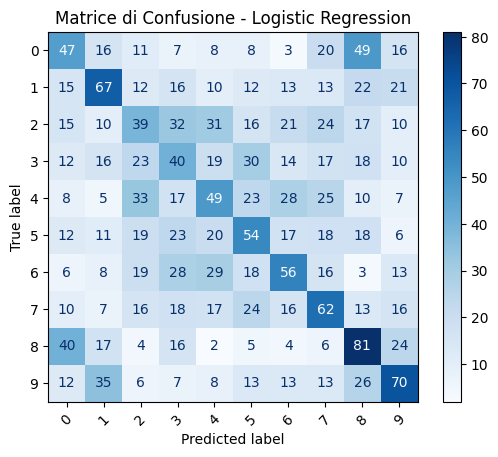


SVM


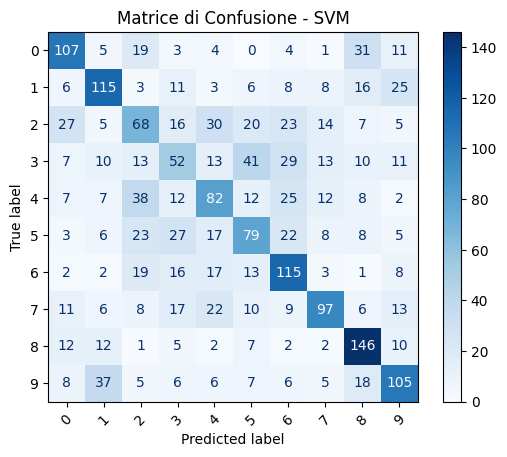


K-NN


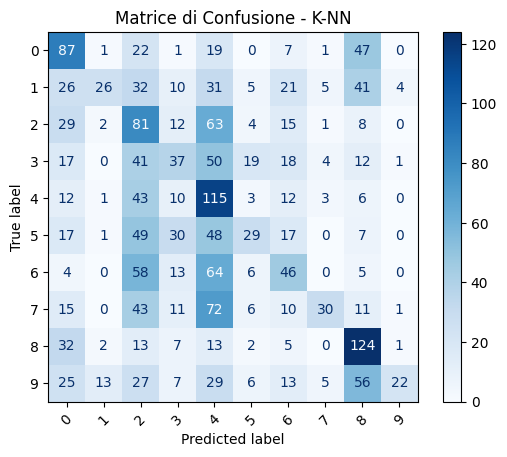


DECISION TREE


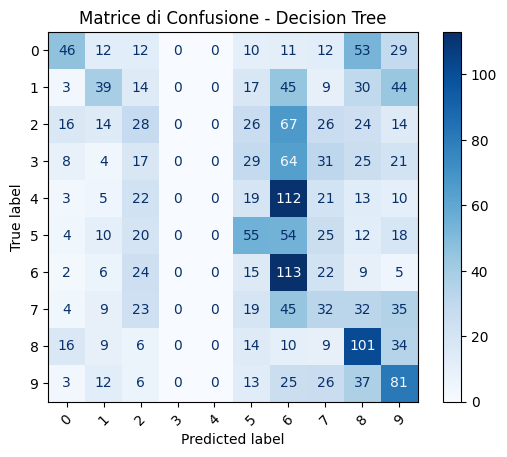

In [10]:
# Visualizza la matrice di confusione
model_dict = {
    "Logistic Regression": logistic_model,
    "SVM": svm_model,
    "K-NN": best_knn,
    "Decision Tree": best_dt
}

for name, model in model_dict.items():
    print(f"\n{name.upper()}")
    
    # Predizione
    y_pred = model.predict(X_test_scaled)
    
    # Matrice di confusione
    cm = confusion_matrix(y_test_reduced, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Matrice di Confusione - {name}")
    plt.show()